In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shl-hiring-assessment/Dataset/sample_submission.csv
/kaggle/input/shl-hiring-assessment/Dataset/train.csv
/kaggle/input/shl-hiring-assessment/Dataset/test.csv
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_885.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_1142.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_1006.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_817.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_765.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_508.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_257.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_330.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_72.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_328.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_858.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/

In [7]:
#Refinement 2

In [8]:
# Step 1: Import Libraries

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [9]:
# Step 2: Load Dataset
train_df = pd.read_csv('/kaggle/input/shl-hiring-assessment/Dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/shl-hiring-assessment/Dataset/test.csv')

In [10]:
# Step 3: Feature Extraction Function
def extract_features_optimized(audio_path):
    try:
        y, sr = librosa.load(audio_path, sr=None, duration=60)
        
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)

        feature_vector = np.hstack([
            np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
            np.mean(chroma, axis=1), np.std(chroma, axis=1),
            np.mean(contrast, axis=1), np.std(contrast, axis=1),
            np.mean(tonnetz, axis=1), np.std(tonnetz, axis=1),
            np.mean(zcr), np.std(zcr),
            np.mean(rmse), np.std(rmse),
            np.mean(spec_cent), np.std(spec_cent)
        ])
        return feature_vector
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        return None

In [11]:
# Step 4: Extract Features from Training Data
X_train, y_train = [], []

for idx, row in train_df.iterrows():
    audio_path = f'/kaggle/input/shl-hiring-assessment/Dataset/audios/train/{row["filename"]}'
    features = extract_features_optimized(audio_path)
    if features is not None:
        X_train.append(features)
        y_train.append(row['label'])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [12]:
# Step 5: Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [13]:
# Step 6: Standard Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [14]:
## Option A: SVR with hyperparameter tuning
svr = SVR(kernel='rbf')
param_grid = {'C': [10, 100], 'gamma': ['scale'], 'epsilon': [0.1]}
grid_svr = GridSearchCV(svr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_svr.fit(X_train, y_train)
svr_model = grid_svr.best_estimator_

In [15]:
## Option B: XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
# Step 7: Train Models
# Choose best model
model = svr_model

In [17]:
# Step 8: Validation Predictions & Evaluation
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
pearson_corr, _ = pearsonr(y_val, y_pred)

print(f"RMSE on Validation Set: {rmse:.4f}")
print(f"Pearson Correlation on Validation Set: {pearson_corr:.4f}")

RMSE on Validation Set: 0.8087
Pearson Correlation on Validation Set: 0.7259


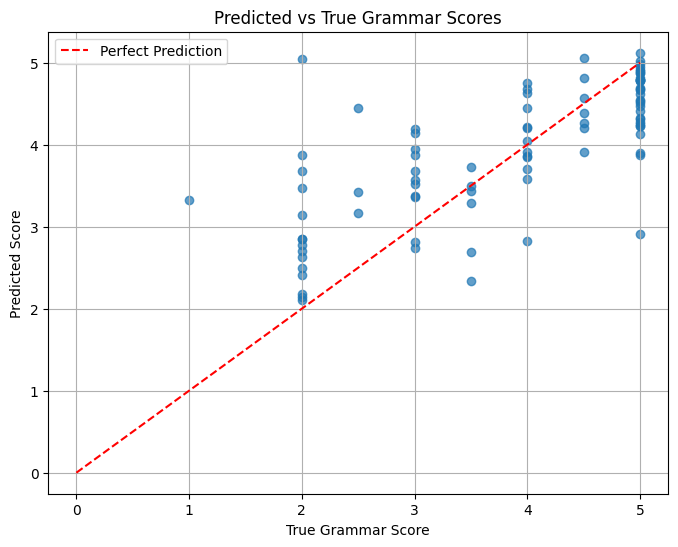

In [18]:
# Step 9: Visualize Predictions
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred, alpha=0.7)
plt.plot([0, 5], [0, 5], '--r', label="Perfect Prediction")
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs True Grammar Scores")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Step 10: Feature Importances (Optional for XGBoost)
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.barh(range(len(indices)), importances[indices], align="center")
    plt.yticks(range(len(indices)), [f"F{i}" for i in indices])
    plt.xlabel("Importance")
    plt.show()


In [20]:
# Step 11: Process Test Set
X_test, missing_files = [], []

for idx, row in test_df.iterrows():
    audio_path = f'/kaggle/input/shl-hiring-assessment/Dataset/audios/test/{row["filename"]}'
    features = extract_features_optimized(audio_path)
    if features is not None:
        X_test.append(features)
    else:
        missing_files.append(row["filename"])

print(f"Total Missing Test Files: {len(missing_files)}")

Total Missing Test Files: 0


In [21]:
X_test = scaler.transform(np.array(X_test))
y_test_pred = model.predict(X_test)
y_test_pred = np.clip(y_test_pred, 0, 5) 

In [22]:
 # Step 12: Prepare Submission
submission = pd.DataFrame({
    'filename': test_df.loc[~test_df['filename'].isin(missing_files), 'filename'],
    'label': y_test_pred
})
submission.to_csv('/kaggle/working/submission.csv', index=False)
print("✅ Submission file created: submission.csv")

✅ Submission file created: submission.csv


In [23]:
# Step 13: RMSE on Full Train Set 
full_train_pred = model.predict(scaler.transform(np.array(X_train)))
rmse_full = np.sqrt(mean_squared_error(y_train, full_train_pred))
print(f"RMSE on Full Training Data: {rmse_full:.4f}")

RMSE on Full Training Data: 1.0245


In [24]:
#Saving Model for future use
import joblib
joblib.dump(model, '/kaggle/working/SHL_model.pkl')
print("Model saved as SHL_model.pkl")


Model saved as SHL_model.pkl


In [25]:
#Visual Data

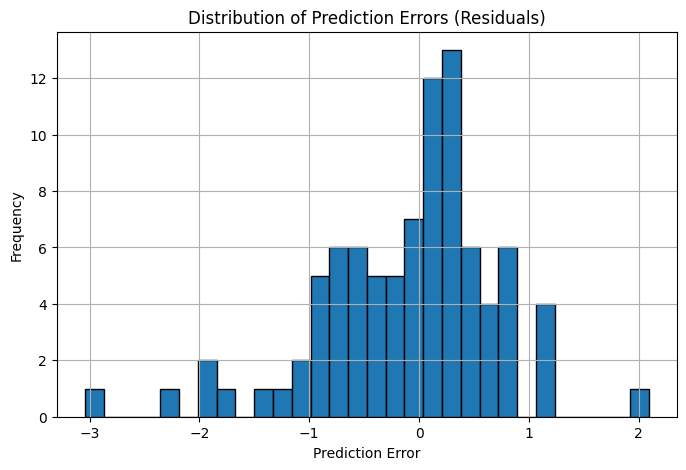

In [26]:
# Residual Plot
residuals = y_val - y_pred
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


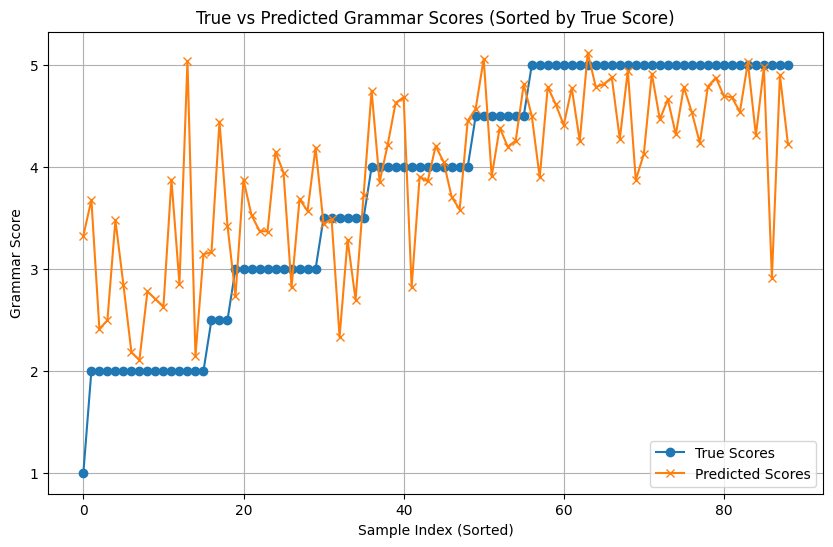

In [27]:
# Line Plot - Sorted View
sorted_idx = np.argsort(y_val)
plt.figure(figsize=(10, 6))
plt.plot(y_val[sorted_idx], label="True Scores", marker='o')
plt.plot(y_pred[sorted_idx], label="Predicted Scores", marker='x')
plt.title("True vs Predicted Grammar Scores (Sorted by True Score)")
plt.xlabel("Sample Index (Sorted)")
plt.ylabel("Grammar Score")
plt.legend()
plt.grid(True)
plt.show()


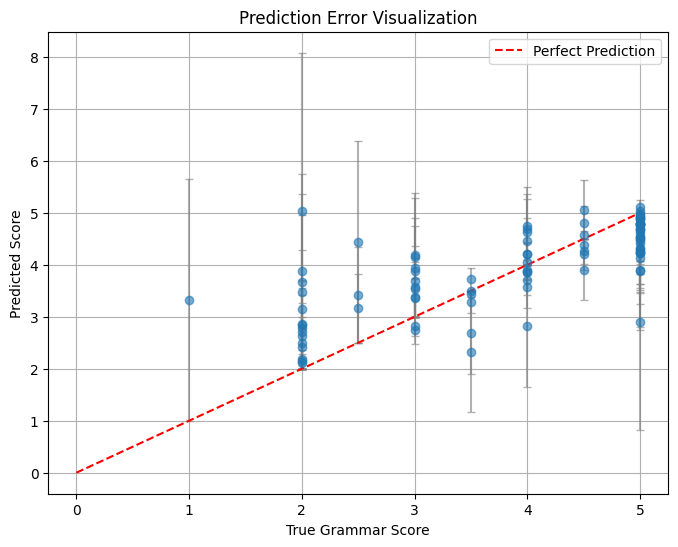

In [28]:
# Error bars scatter plot
errors = np.abs(y_pred - y_val)
plt.figure(figsize=(8, 6))
plt.errorbar(y_val, y_pred, yerr=errors, fmt='o', ecolor='gray', alpha=0.6, capsize=3)
plt.plot([0, 5], [0, 5], '--r', label="Perfect Prediction")
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Score")
plt.title("Prediction Error Visualization")
plt.grid(True)
plt.legend()
plt.show()


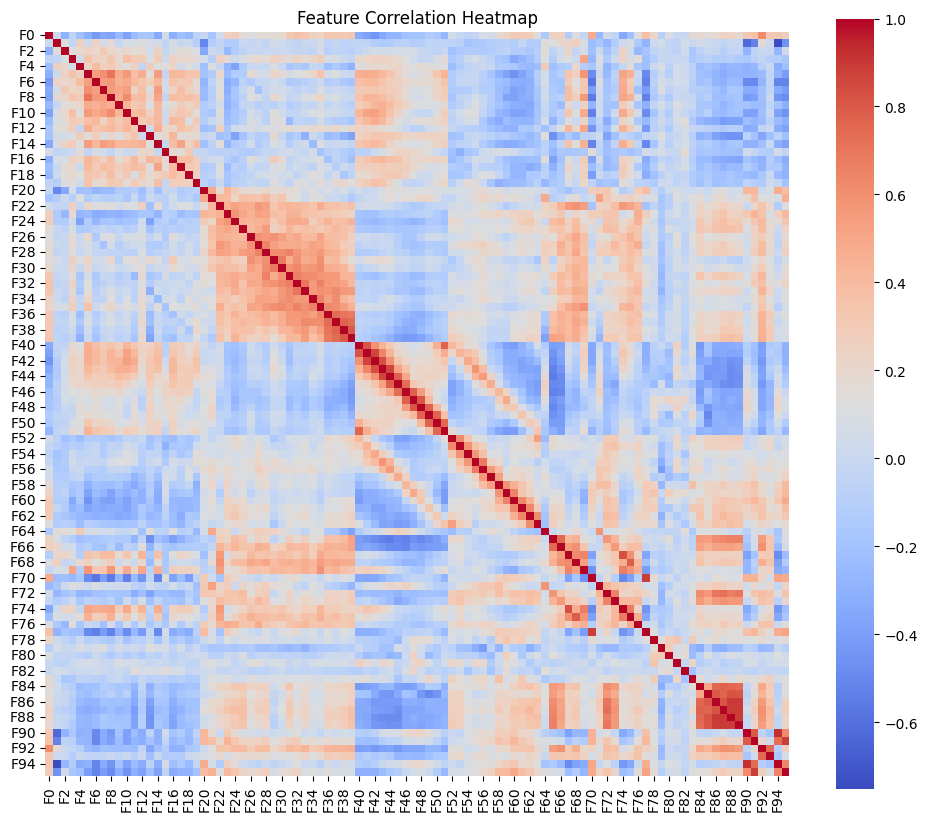

In [34]:
import seaborn as sns

# Create DataFrame for feature names if needed
feature_names = [f"F{i}" for i in range(X_train.shape[1])]
df_features = pd.DataFrame(X_train, columns=feature_names)

# Correlation Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df_features.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", square=True)
plt.title("Feature Correlation Heatmap")
plt.show()


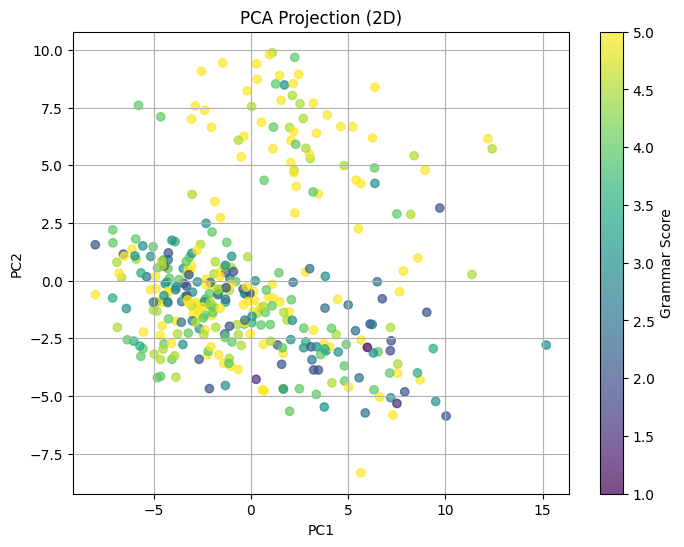

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.colorbar(label="Grammar Score")
plt.title("PCA Projection (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


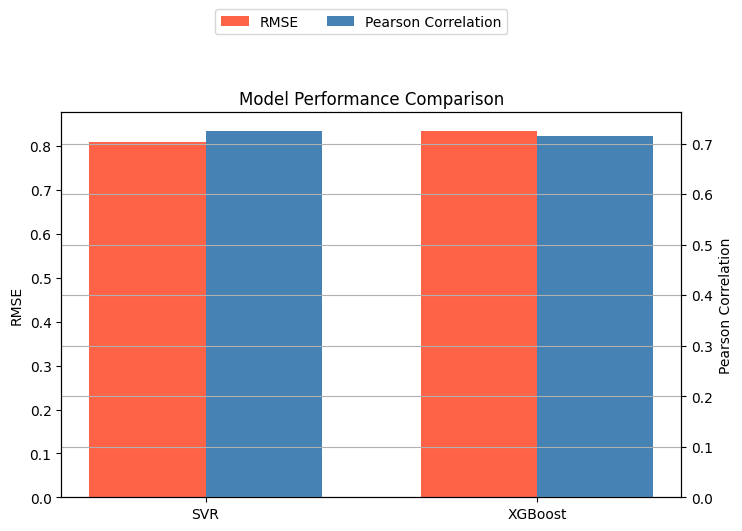

In [32]:
# Example: compare SVR vs XGB
model_names = ['SVR', 'XGBoost']
rmse_scores = [rmse, np.sqrt(mean_squared_error(y_val, xgb_model.predict(X_val)))]
pearson_scores = [pearsonr(y_val, svr_model.predict(X_val))[0], pearsonr(y_val, xgb_model.predict(X_val))[0]]

x = np.arange(len(model_names))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8,5))
ax2 = ax1.twinx()

ax1.bar(x - width/2, rmse_scores, width, label='RMSE', color='tomato')
ax2.bar(x + width/2, pearson_scores, width, label='Pearson Correlation', color='steelblue')

ax1.set_ylabel('RMSE')
ax2.set_ylabel('Pearson Correlation')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
plt.title("Model Performance Comparison")
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.grid(True)
plt.show()


In [33]:
summary_df = pd.DataFrame({
    "Model": ["SVR", "XGBoost"],
    "RMSE": [rmse, np.sqrt(mean_squared_error(y_val, xgb_model.predict(X_val)))],
    "Pearson Correlation": [pearson_corr, pearsonr(y_val, xgb_model.predict(X_val))[0]]
})
print(summary_df.round(4))


     Model    RMSE  Pearson Correlation
0      SVR  0.8087               0.7259
1  XGBoost  0.8355               0.7160
